# MIT License

Copyright 2020 Pablo Duboue

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

This code is derived from the Case Study in Chapter 7, see https://github.com/DrDub/artfeateng

# WikiCountries

Let us start by identifying all entities of type http://dbpedia.org/ontology/Country (Cell #18).

Countries have lots of relations coming into them, as expected. We can now merge the time series data with the relations data and split into training data and final test data (Cell #23).

In [1]:
# from CELL 23
import random
import os

rels = dict()
with open(os.path.join("..", "data", "ch7_cell22_rels_in_out.tsv")) as tsv:
    next(tsv) # header
    for line in tsv:
        country, rels_out, rels_in = line.strip().split("\t")
        rels[country] =  (int(rels_out), int(rels_in))

mapping = dict()
with open(os.path.join("..", "data", "ch7_cell21_wb_uri_mapping.tsv")) as m:
    for line in m:
        wb, db = line.strip().split("\t")
        mapping[wb] = db

data = list()
with open(os.path.join("..", "data", "ch7_cell19_wb_pop.tsv")) as wb:
    line = next(wb)
    header = line.strip().split("\t")
    header.insert(1, "rels_out")
    header.insert(2, "rels_in")
    for line in wb:
        fields = line.strip().split("\t")
        wb_country = fields.pop(0)
        if wb_country not in mapping:
            continue
        db_country = mapping[wb_country]
        fields = list(map(lambda x: 0 if x == '' else int(x),fields))
        fields.insert(0, rels[db_country][1])
        fields.insert(0, rels[db_country][0])
        data.append( (wb_country, fields) )
print("Data for {:,} countries".format(len(data)))
        
# save all data
with open(os.path.join("..", "data", "cell23_countries_data.tsv"), "w") as tsv:
    tsv.write("\t".join(header) + "\n")
    for name, fields in data:
        tsv.write(name + "\t" + "\t".join(map(str,fields)) + "\n")

# split train and final test
rand = random.Random(42)
rand.shuffle(data)
pivot = int(len(data) * 0.8)
devset = data[:pivot]
heldout = data[pivot:]
with open(os.path.join("..", "data", "cell23_countries_dev.tsv"), "w") as dev:
    dev.write("\t".join(header) + "\n")
    for name, fields in devset:
        dev.write(name + "\t" + "\t".join(map(str,fields)) + "\n")
with open(os.path.join("..", "data", "cell23_countries_held.tsv"), "w") as held:
    held.write("\t".join(header) + "\n")
    for name, fields in heldout:
        held.write(name + "\t" + "\t".join(map(str,fields)) + "\n")
print("Devset size: {:,}".format(len(devset)))
print("Heldout size: {:,}".format(len(heldout)))

Data for 217 countries
Devset size: 173
Heldout size: 44


With the data split properly, we can start some EDA on it.

## EDA

Let's plot the relations and current population to see if there is a correlation (Cell #24).

<module 'matplotlib.pyplot' from '/home/pablo/local/virtualenv/feateng/lib/python3.6/site-packages/matplotlib/pyplot.py'>

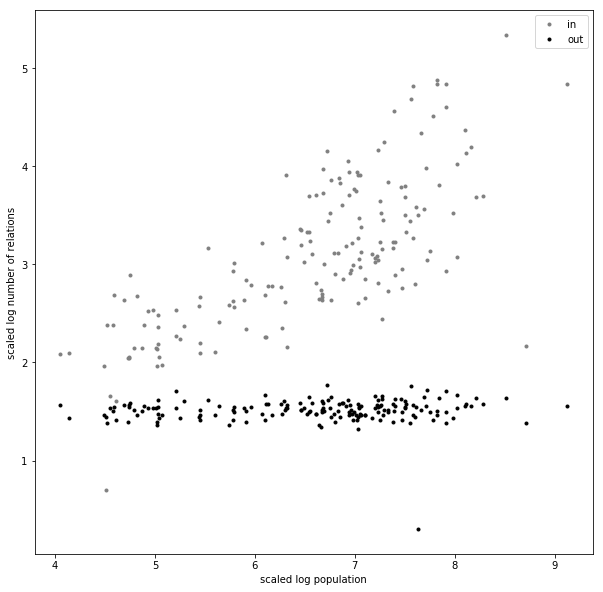

In [2]:
# from CELL 24
import math

pops = list()
num_in_rels = list()
num_out_rels = list()
with open(os.path.join("..", "data", "cell23_countries_dev.tsv")) as feats:
    next(feats) # skip header
    for line in feats:
        fields = line.strip().split("\t")
        pop = float(fields[-1])
        out_rels = float(fields[1])
        in_rels = float(fields[2])
        if out_rels == 0:
            continue
        pops.append(math.log(pop, 10))
        num_out_rels.append(math.log(out_rels, 10))
        num_in_rels.append(math.log(in_rels, 10))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(pops, num_in_rels, '.', color='gray', label='in')
plt.plot(pops, num_out_rels, '.', color='black', label='out')
plt.xlabel('scaled log population')
plt.ylabel('scaled log number of relations')
plt.savefig(os.path.join("..", "media", "cell24_logpop_vs_log_items.pdf"), bbox_inches='tight', dpi=300)
plt.legend()
plt

From the figure we can see that the number of in relations is informative, but the number of out relations is not, most of the countries are involved in the same number of standard relations.

Let us now take 10 random countries and look at their time series data (Cell #25).

<module 'matplotlib.pyplot' from '/home/pablo/local/virtualenv/feateng/lib/python3.6/site-packages/matplotlib/pyplot.py'>

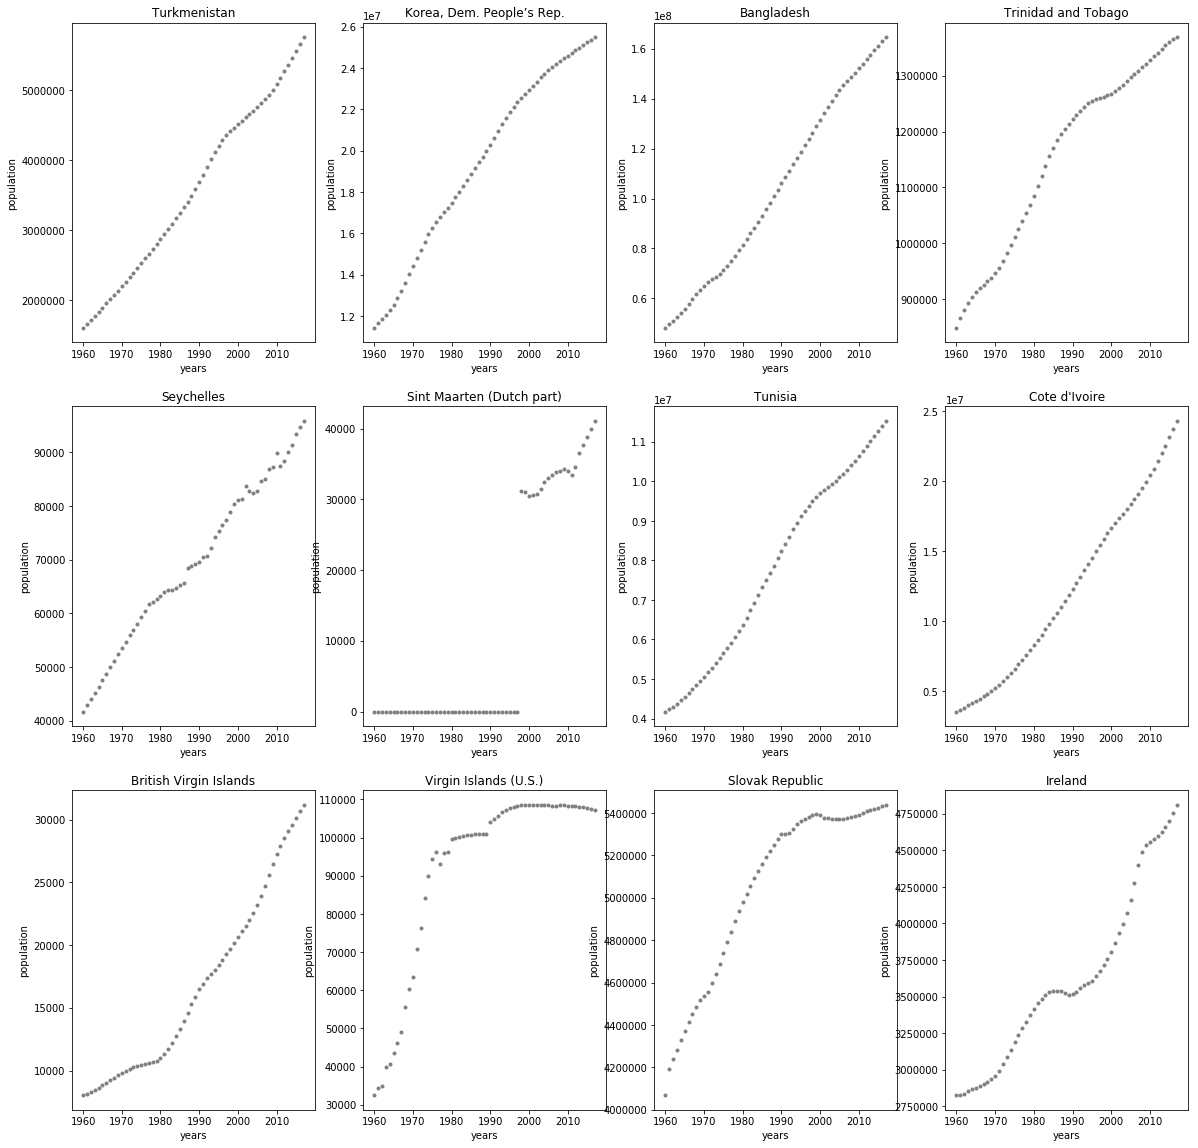

In [3]:
# from CELL 25
import math
import random

years = list()
data = list()
with open(os.path.join("..", "data", "cell23_countries_dev.tsv")) as feats:
    header = next(feats).strip().split("\t")
    years = list(map(int,header[3:]))
    for line in feats:
        fields = line.strip().split("\t")
        data.append( (fields[0], list(map(int,fields[3:]))) )
        
rand = random.Random(42)
rand.shuffle(data)
to_show = data[:12]

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

for idx, row in enumerate(to_show):
    plt.subplot(len(to_show) // 4, 4, idx + 1)
    
    plt.plot(years, row[1], '.', color='gray')
    plt.xlabel('years')
    plt.ylabel('population')
    plt.title(row[0])
    
plt.savefig(os.path.join("..", "media", "cell25_sample_country_pop.pdf"), bbox_inches='tight', dpi=300)
plt

In the figure we can see trend reversal (Ireland in the 1980-1990, Slovak Republic in 2000-2010), missing data (Sint Maarten) and a variety of curves.

## No TS data

Let us start by using only the number of relations (Cell #33)

Training on 140 countries
C 0.01 RMSE 1.074204810382449
C 0.1 RMSE 0.8090564628670425
C 0.5 RMSE 0.7091245240776414
C 1.0 RMSE 0.7177892887020444
C 1.5 RMSE 0.7159910497027021
C 2.0 RMSE 0.7054068673855378
C 5.0 RMSE 0.7028442756177381
C 10.0 RMSE 0.6974059125373744
C 50.0 RMSE 0.7169340339921172
C 100.0 RMSE 0.7725200419969165
Best C 10.0 best RMSE 0.6974059125373744
Epsilon 0.0001 RMSE 0.6913114694367364
Epsilon 0.001 RMSE 0.6871954628240701
Epsilon 0.01 RMSE 0.6951797961785875
Epsilon 0.02 RMSE 0.695918991384224
Epsilon 0.05 RMSE 0.6974059125373744
Epsilon 0.1 RMSE 0.6834592511300636
Epsilon 0.2 RMSE 0.7231458831001565
Epsilon 0.5 RMSE 1.1225989857188645
Epsilon 0.0 RMSE 0.6914775913481219
Epsilon 1.0 RMSE 1.1225989857188645
Epsilon 10.0 RMSE 1.1225989857188647
Epsilon 100.0 RMSE 1.1225989857188663
Best epsilon 0.1 best RMSE 0.6834592511300636
RMSE 0.6512360835560099


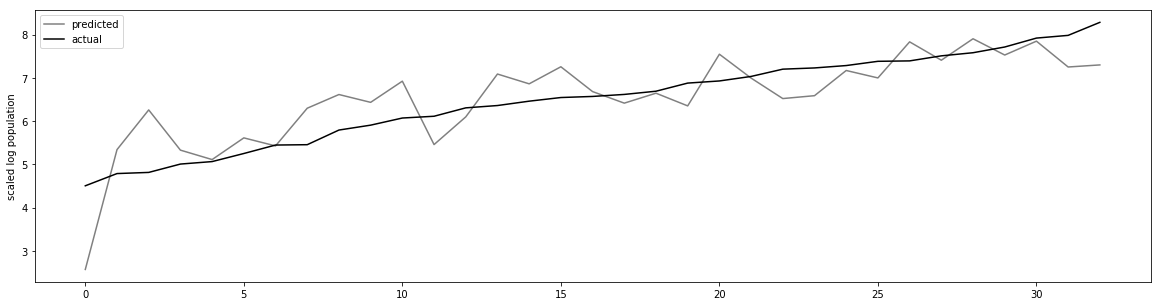

In [4]:
# from CELL 33
import math
import random
from sklearn.svm import SVR
import numpy as np

rand = random.Random(42)
train_data = list()
test_data = list()
header = None
with open(os.path.join("..", "data", "cell23_countries_dev.tsv")) as feats:
    header = next(feats)
    header = header.strip().split("\t")
    header = [ header[0], "log_" + header[1], "log_" + header[2], "logpop" ]
    for line in feats:
        fields = line.strip().split("\t")
        name = fields[0]
        pop = float(fields[-1])
        out_rels = float(fields[1])
        in_rels = float(fields[2])
        if out_rels == 0:
            out_rels = 1
        row = ( [ math.log(out_rels, 10), math.log(in_rels, 10) ], math.log(pop, 10), name )
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
            
with open(os.path.join("..", "data", "cell33_feat1.tsv"), "w") as feat:
    feat.write("\t".join(header) + "\n")
    for feats, logpop, name in train_data + test_data:
        feat.write("{}\t{}\t{}\n".format(name, "\t".join(map(str,feats)), logpop))
               
test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# SVRs need scaling
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_orig = ytrain.copy()
ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# train
print("Training on {:,} countries".format(len(xtrain)))

best_c = 100.0
best_epsilon = 0.05

SEARCH_TEST = 50
best_rmse = 1000
for c in [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 50.0, 100.0]:
    svr_rbf = SVR(epsilon=0.05, C=c, gamma='auto')
    svr_rbf.fit(xtrain[:-SEARCH_TEST,:], ytrain[:-SEARCH_TEST])
    ytrain_pred_end = svr_rbf.predict(xtrain[-SEARCH_TEST:,:])
    ytrain_pred_end *= 1.0/ytrain_scaling
    ytrain_pred_end += ytrain_min
    RMSE = math.sqrt(sum((ytrain_orig[-SEARCH_TEST:] - ytrain_pred_end)**2) / SEARCH_TEST)
    print("C", c, "RMSE", RMSE)
    if RMSE < best_rmse:
        best_c = c
        best_rmse = RMSE

print("Best C", best_c,"best RMSE", best_rmse)        

best_rmse = 1000
for epsilon in [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.0, 1.0, 10.0, 100.0]:
    svr_rbf = SVR(epsilon=epsilon, C=best_c, gamma='auto')
    svr_rbf.fit(xtrain[:-SEARCH_TEST,:], ytrain[:-SEARCH_TEST])
    ytrain_pred_end = svr_rbf.predict(xtrain[-SEARCH_TEST:,:])
    ytrain_pred_end *= 1.0/ytrain_scaling
    ytrain_pred_end += ytrain_min
    RMSE = math.sqrt(sum((ytrain_orig[-SEARCH_TEST:] - ytrain_pred_end)**2) / SEARCH_TEST)
    print("Epsilon", epsilon, "RMSE", RMSE)
    if RMSE < best_rmse:
        best_epsilon = epsilon
        best_rmse = RMSE

print("Best epsilon", best_epsilon,"best RMSE", best_rmse)

svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig(os.path.join("..", "media", "cell33_svr_feat1.pdf"), bbox_inches='tight', dpi=300)
plt.legend()

The RMSE is very small for the amount of training data and pauperity of the features. Let us add the TS as extra features.

##  Using TS as Features

I will also try to find the range that produces the best results (Cell #34).

Training on 140 countries
History 1
Best C 1.5 best RMSE 0.12233640335264187
Best epsilon 0.0001 best RMSE 0.03251167662471664
History 2
Best C 1.5 best RMSE 0.11938965515214714
Best epsilon 0.0 best RMSE 0.029216829709028978
History 3
Best C 1.0 best RMSE 0.1182001900295011
Best epsilon 0.0001 best RMSE 0.03130831272980187
History 4
Best C 0.5 best RMSE 0.11731038389815374
Best epsilon 0.001 best RMSE 0.04048445439648792
History 5
Best C 1.0 best RMSE 0.11746844884537583
Best epsilon 0.0 best RMSE 0.031175872317681545
History 6
Best C 1.0 best RMSE 0.11775230311849348
Best epsilon 0.0 best RMSE 0.03174244213583967
History 7
Best C 0.5 best RMSE 0.11817988976893384
Best epsilon 0.0 best RMSE 0.043828397192121886
History 8
Best C 0.5 best RMSE 0.11876236428723513
Best epsilon 0.0001 best RMSE 0.043602656633612985
History 9
Best C 0.5 best RMSE 0.11985469751900125
Best epsilon 0.0001 best RMSE 0.04405567070698307
History 10
Best C 0.5 best RMSE 0.12127441973124253
Best epsilon 0.0001 bes

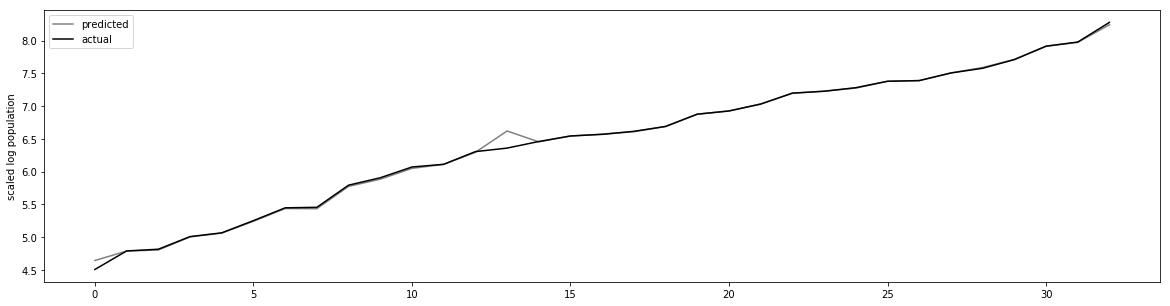

In [5]:
# from CELL 34
import math
import random
from sklearn.svm import SVR
import numpy as np

rand = random.Random(42)
train_data = list()
test_data = list()
header = None
with open(os.path.join("..", "data", "cell23_countries_dev.tsv")) as feats:
    header = next(feats)
    logheader = list(map(lambda x:"log_"+x, header.strip().split("\t")))
    header = [ header[0] ] + logheader[1:-1] + [ "logpop" ]
    for line in feats:
        fields = line.strip().split("\t")
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:-1]))
        for idx, feat in enumerate(feats):
            if feat == 0:
                feats[idx] = 1
        row = ( list(map(lambda x:math.log(x, 10), feats)), math.log(pop, 10), name )
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
            
test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

full_xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
full_xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# SVRs need scaling
full_xtrain_min = full_xtrain.min(axis=0); full_xtrain_max = full_xtrain.max(axis=0)
# some can be zero if the column is constant in training
full_xtrain_diff = full_xtrain_max - full_xtrain_min
for idx in range(len(full_xtrain_diff)):
    if full_xtrain_diff[idx] == 0.0:
        full_xtrain_diff[idx] = 1.0
full_xtrain_scaling = 1.0 / full_xtrain_diff
full_xtrain -= full_xtrain_min; full_xtrain *= full_xtrain_scaling

ytrain_orig = ytrain.copy()
ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

full_xtest_orig = full_xtest.copy()
full_xtest -= full_xtrain_min; full_xtest *= full_xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# train
print("Training on {:,} countries".format(len(full_xtrain)))
               
best_history = len(header) - 5
best_history_rmse = 1000
best_history_c = 100.0
best_history_epsilon = 0.05

for history in range(1, len(header) - 5):
    
    print("History", history)
    
    xtrain = np.zeros( (full_xtrain.shape[0], 2 + history))
    xtrain[:,:2] = full_xtrain[:,:2] # rels
    xtrain[:, 2:] = full_xtrain[:,-history:]
    
    best_c = 100.0
    best_epsilon = 0.05

    SEARCH_TEST = 50
    best_rmse = 1000
    for c in [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 50.0, 100.0]:
        svr_rbf = SVR(epsilon=0.05, C=c, gamma='auto')
        svr_rbf.fit(xtrain[:-SEARCH_TEST,:], ytrain[:-SEARCH_TEST])
        ytrain_pred_end = svr_rbf.predict(xtrain[-SEARCH_TEST:,:])
        ytrain_pred_end *= 1.0/ytrain_scaling
        ytrain_pred_end += ytrain_min
        RMSE = math.sqrt(sum((ytrain_orig[-SEARCH_TEST:] - ytrain_pred_end)**2) / SEARCH_TEST)
        if RMSE < best_rmse:
            best_c = c
            best_rmse = RMSE

    print("Best C", best_c,"best RMSE", best_rmse)        

    best_rmse = 1000
    for epsilon in [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.0, 1.0, 10.0, 100.0]:
        svr_rbf = SVR(epsilon=epsilon, C=best_c, gamma='auto')
        svr_rbf.fit(xtrain[:-SEARCH_TEST,:], ytrain[:-SEARCH_TEST])
        ytrain_pred_end = svr_rbf.predict(xtrain[-SEARCH_TEST:,:])
        ytrain_pred_end *= 1.0/ytrain_scaling
        ytrain_pred_end += ytrain_min
        RMSE = math.sqrt(sum((ytrain_orig[-SEARCH_TEST:] - ytrain_pred_end)**2) / SEARCH_TEST)
        if RMSE < best_rmse:
            best_epsilon = epsilon
            best_rmse = RMSE

    print("Best epsilon", best_epsilon,"best RMSE", best_rmse)

    if best_rmse < best_history_rmse:
        best_history_rmse = best_rmse
        best_history = history
        best_history_c = best_c
        best_history_epsilon = best_epsilon

print("Best history", best_history, "best c", best_c, "best epsilon", best_epsilon,"best RMSE", best_rmse)

xtrain = np.zeros( (full_xtrain.shape[0], 2 + best_history))
xtrain[:,:2] = full_xtrain[:,:2] # rels
xtrain[:, 2:] = full_xtrain[:,-best_history:]

xtest = np.zeros( (full_xtest.shape[0], 2 + best_history))
xtest[:,:2] = full_xtest[:,:2] # rels
xtest[:, 2:] = full_xtest[:,-best_history:]

svr_rbf = SVR(epsilon=best_history_epsilon, C=best_history_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

# use previous year to predict current

RMSE = math.sqrt(sum((full_xtest_orig[:,-1] - ytest_pred)**2) / len(ytest))
print("Previous year RMSE", RMSE)
               
with open(os.path.join("..", "data", "cell34_feat2.tsv"), "w") as feat:
    feat.write("\t".join(header[:2] + header[-(best_history+1):]) + "\n")
    for feats, logpop, name in train_data + test_data:
        feat.write("{}\t{}\t{}\n".format(name, "\t".join(map(str,feats[:2] + feats[-best_history:])), logpop))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig(os.path.join("..", "media", "cell34_svr_feat2.pdf"), bbox_inches='tight', dpi=300)
plt.legend()